# US NFDRS Version 4.0 Live Fuel Moisture Model Evaluation and Calibration
W. Matt Jolly, william.jolly@usda.gov<br>
Patrick H. Freeborn, patrick.h.freeborn@usda.gov<br>
USDA Forest Service<br>
RMRS Fire Sciences Laboratory<br>
Fire, Fuel and Smoke Program<br>
5775 Hwy 10 W<br>
Missoula, MT 59808<br>


In [1]:
import math, sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import *
from scipy.stats import spearmanr,stats
from sklearn.metrics import mean_absolute_error
from pandas.plotting import register_matplotlib_converters
import matplotlib.cm as cm
register_matplotlib_converters()
from matplotlib.dates import DateFormatter
from NFDRSV4PubGraphicsOptions import *
import warnings
warnings.filterwarnings('ignore')

In [3]:
### Basic met functions, photoperiod and conversions

## fToC Converts Fahrenheit to Celcius
## Inputs: f: Temperature in deg F
## Returns: c: Temperature in deg C
def fToc(f):
    return (f -32) * 5/9

## cTof Converts Celcius to Fahrenheit
## Inputs: c: Temperature in deg C
## Returns: f: Temperature in deg F
def cTof(c):
    return (c * 9/5) + 32
INC = 0	#GSI Function Types, Increasing (Tmin, Dayl)
DEC = 1 #GSI Function Types, Decreasing (VPD)
MM_2_IN = 0.0393701  # Conversion factor from mm to inches
KPH_2_MPH = 0.621371 # Conversion factor from KPH to MPH

## Calculate the Photoperiod/Daylength from latitude and day of year (yearday)
## Inputs: lat: Latitude in Degrees (90 to -90)
##         yday: Yearday (1-366)
def CalcDayl(lat,yday):
    RADPERDAY = 0.017214
    RADPERDEG = 0.01745329
    MINDECL = -0.4092797
    SECPERRAD = 13750.9871
    DAYSOFF = 10.25
    # Daylength function from MT-CLIM */
    lat = lat * RADPERDEG
    if lat > 1.5707:
        lat = 1.5707
    if lat < -1.5707:
        lat = -1.5707
    coslat = math.cos(lat)
    sinlat = math.sin(lat)

    #* calculate cos and sin of declination */
    decl = MINDECL * math.cos((yday + DAYSOFF) * RADPERDAY)
    cosdecl = math.cos(decl)
    sindecl = math.sin(decl)
    cosegeom = coslat * cosdecl
    sinegeom = sinlat * sindecl
    coshss = -(sinegeom) / cosegeom
    if coshss < -1.0:
        coshss = -1.0  # 24-hr daylight */
    if coshss > 1.0:
        coshss = 1.0    # 0-hr daylight */
    hss = math.acos(coshss)                # hour angle at sunset (radians) */
    #* daylength (seconds) */
    return 2.0 * hss * SECPERRAD

# Function to calculate the Saturation Vapor Pressure for a given temperature.
# Note: Function converts internally from F to C.
# Input: tempF: Temperature in Deg F
# Return: Saturation Vapor Pressure (Pa)
def CalcVP(tempF):
    tmpC =  (tempF - 32.0) / 1.8
    vp = 610.7 * math.exp((17.38 * tmpC)/(239 + tmpC))
    return vp

# Calculate the VPD from RH and temperature
# Inputs: RH: Relative Humidity in Percent (1-100)
#         TempF: Temperature in Deg F
# Return: Vapor Pressure Deficit (Pa)
def CalcVPD(RH, TempF):
    vp = CalcVP(TempF)
    vpd = vp - (RH / 100) * vp
    if(vpd < 0.0):
        vpd = 0.0;
    return vpd



In [4]:
# A class to contains all of the parameters used to derived GSI.  This makes it easier to iterate through parameter spaces for
# for optimization
class GSILimits:
    TminLow = -2       # Lower limit for minimum temperature (C)
    TminUp = 5         # Upper limit for minimum temperature (C)
    DaylLow = 36000    # Lower limit for daylength (seconds)
    DaylUp = 39600     # Upper limit for daylength (seconds)
    VPDLow = 900       # Lower limit for VPD (pascals)
    VPDUp = 4100       # Upper limit for VPD (pascals)
    PrcpRTLow = 0    # Lower limit for running total precip (inches)
    PrcpRTUp = 0.393     # Upper limit for running total precip (inches)
    PrcpRTPeriod = 28  # Running total period for precipitaiton (days)
    GSIPeriod = 28     # Running average period for final GSI (days)
    GUThresh = 0.2    # Green-up threshold (dim)
    LFMMax = 200       # Maximum fuel moisture (% dry wt)
    LFMMin = 60        # Minimum fuel moisture (% dry wt)
    Lat = 45           # Station latitude (degrees)

In [5]:
# Helper function to set the GSI Limits class values based on the list of calibrated parameters
# gsilim: An instance of the GSILimits class
# gsiparams: an 11 element list of GSI parameters
# LFMMin: minimum live fuel moisture limit for model
# LFMMax: maximum live fuel moisture limit for model
# Lat: Latitude of the estimatation location (used in photoperiod calculations)
def SetGSILimits(gsilim,gsiparams,LFMMin,LFMMax, Lat):
    gsilim.TminLow = gsiparams[0] 
    gsilim.TminUp = gsiparams[1]
    gsilim.VPDLow = gsiparams[2]
    gsilim.VPDUp = gsiparams[3]
    gsilim.DaylLow = gsiparams[4]
    gsilim.DaylUp = gsiparams[5]
    gsilim.PrcpRTLow = gsiparams[6]
    gsilim.PrcpRTUp = gsiparams[7]
    gsilim.GSIPeriod = gsiparams[8]
    gsilim.GUThresh = gsiparams[9]
    gsilim.PrcpRTPeriod = gsiparams[10]
    gsilim.LFMMin = LFMMin
    gsilim.LFMMax = LFMMax
    gsilim.Lat = Lat
    return gsilim

## Ramp function for GSI calculations

In [6]:
# GSI indicator/ramp function
def Ind(Var,Low,Up):
    # Make sure all the input variables are numbers
    Var = float(Var)
    Low = float(Low)
    Up = float(Up)
    if(Up == Low):  # Upper (Up) and Lower (Low) can't be the same
        return 0
    if( Var < Low):  # If the variables is less than the lower limit, return 0
        return 0
    elif(Var > Up):  # If the variables is greater than the upper limit, return 1
        return 1
    else:            # If the variables is between the lower and upper limits, return the proportion
        return (Var - Low) / (Up - Low)

## Function to calculate the Growing Season Index

In [7]:
# Function to calculate GSI, Scaled GSI and Live Fuel Moisture on a DataFrame
# df: Pandas DataFrame of daily weather data
# assumes the following labeled columns: "Tmin: minimum temperature (deg F), VPDMax: Max daily VPD (Pa)
#                                          and Prcp: 24 hour total precipitation (Inches)"
# gsilim: An instance of the GSILimits class 
# PLowLim and PUpperLim: Date range for model predictions

def CalcGSI(df,gsilim,PLowLim='2014-01-01',PUpperLim = '2020-12-31'):
    # Filter the dataset for a 5 year period
    df = df[(df['DateTime'] > PLowLim) & (df['DateTime'] <= PUpperLim)].copy()
    # Compute and store the day of the year for use in calculating Daylength
    df['JDay'] = df.DateTime.dt.dayofyear
    # Minimum Temperature
    df['TminC'] =  (df.Tmin - 32.0) * 5.0 / 9.0; # Convert Tmin from Fahrenheit to celcuius
    df['TminInd'] = df.apply(lambda row: Ind(row['TminC'],gsilim.TminLow,gsilim.TminUp),axis=1)
    # Vapor Pressure Deficit
    df['VPDInd']= df.apply(lambda row: 1 - Ind(row['VPDMax'],gsilim.VPDLow,gsilim.VPDUp),axis=1)
    # Photoperiod / Daylength
    # First, calculate the Daylength for each observation day (this uses site latitude and julian day)
    df['Dayl'] = df.apply(lambda row: CalcDayl(gsilim.Lat,row['JDay']),axis=1)  
    df['DaylInd']= df.apply(lambda row: Ind(row['Dayl'],gsilim.DaylLow,gsilim.DaylUp),axis=1)
    # Running Total Precipitation
    df['Prcp_RT'] = df['Prcp'].rolling(gsilim.PrcpRTPeriod).sum()
    df['PrcpInd'] = df.apply(lambda row: Ind(row['Prcp_RT'],gsilim.PrcpRTLow,gsilim.PrcpRTUp),axis=1)

    #################################################################                  
    # Daily GSI for four ramp model
    df['iGSI_PE'] = df['TminInd'] * df['VPDInd'] * df['DaylInd'] * df['PrcpInd']
    # Smoothed GSI (running average over the GSIPeriod)
    df['GSI_PE'] = df['iGSI_PE'].rolling(gsilim.GSIPeriod).mean()
    # Rescale the final GSI time series
    df['GSI_PE_RS'] = df['GSI_PE']/ df['GSI_PE'].quantile(1)

    # Calculate LFMC from Rescaled GSI
    df['LFMC'] = df.apply(lambda row: CalcLFMFromGSI(row['GSI_PE_RS'],gsilim.GUThresh,gsilim.LFMMin, gsilim.LFMMax),axis=1)
    return df


## Transform GSI to LFMC

In [8]:
## Function to transform GSI to LFMC
def CalcLFMFromGSI(gsi,GUThresh,LFMMin,LFMMax):
    m = (LFMMax - LFMMin) / (1 - GUThresh)
    b = LFMMax - m
    # Scale GSI between min and max LFMC if gsi is above the green-up threshold
    if(gsi >= GUThresh):
        LFM = m*gsi + b
    # Below the Green-up Threshold, set the value to minimum LFM
    else:
        LFM = LFMMin
    return(LFM)

## Function to calculate and compare GSI using weather obs, measured LFMC and a set of GSI-LFM parameters

In [9]:
# Produce a table entry comparing 78 and GSI/GSIp LFM to Observations
def MakeGSILFMCompareTable4Param(Temp,LFMObs,BestParams,label="",UseLFMMinMax = True,Herb=True,Lat=45):
    PLowLim='2015-01-01'
    PUpperLim = '2019-12-31'
    
    # Label the DataFrame columns so they match the GSI function
    Temp = Temp.rename(columns={"MinT": "Tmin", "VPDM": "VPDMax", "Rain":"Prcp"})
    # Lookup the appropriate live fuel moisture ranges
    LFMMin,LFMMax = GetLFMRange(LFMObs,UseLFMMinMax,Herb)
    gsilim = GSILimits
    newgsilim = SetGSILimits(gsilim,BestParams,LFMMin,LFMMax,Lat)
    
    # Calculate the GSI
    t = CalcGSI(Temp,newgsilim)
    
    # Assign the components back to the dataframe
    Temp['GSI_PE_RS'] = t['GSI_PE_RS']
    Temp['LFMC'] = t['LFMC']  
    Temp['TminInd'] = t['TminInd']
    Temp['VPDInd'] = t['VPDInd']
    Temp['DaylInd'] = t['DaylInd']
    Temp['PrcpInd'] = t['PrcpInd']
    
    # Merge the GSI and LFM obs dataframes
    MetLFMMerge = LFMObs.merge(Temp, left_on='DateTime', right_on='DateTime', suffixes=(False, False))

    # Trim the dataset to the analysis date range
    MetLFMMerge = MetLFMMerge[(MetLFMMerge['DateTime'] > PLowLim) & (MetLFMMerge['DateTime'] <= PUpperLim)]
 
    # Compare the GSI-LFMC (NFDRS-V4) to measured LFMC
    s2,p2 = spearmanr(MetLFMMerge['Percent'],MetLFMMerge['LFMC']*100,nan_policy="omit")
    mae2 = mean_absolute_error(MetLFMMerge['Percent'], MetLFMMerge['LFMC'])
    
    # Compare the old LFMC (NFDRS V2) to measure LFMC
    if Herb:
        s3,p3 = spearmanr(MetLFMMerge['Percent'],MetLFMMerge['FMH'])
        mae3 = mean_absolute_error(MetLFMMerge['Percent'], MetLFMMerge['FMH'])
    else:
        s3,p3 = spearmanr(MetLFMMerge['Percent'],MetLFMMerge['FMW'])
        mae3 = mean_absolute_error(MetLFMMerge['Percent'], MetLFMMerge['FMW'])
    
    return([label,round(s2,3),round(p2,3),round(mae2,3),round(s3,3),round(p3,3),round(mae3,3),len(MetLFMMerge['Percent'])])

In [10]:
# Function to provide a bounded list of lower and upper values that ensures 
# that min is always less than max
# To be used in a Grid Search Optimization for GSI parameters
def MakeParamRange(minValue,maxValue,interv):
    lower = []
    upper = []
    for x in range(minValue,maxValue+1,interv): 
        for y in range(minValue,maxValue+1,interv):
            if(x < y):
                #print(paste(x,y))
                lower.append(x)
                upper.append(y)
    d = {'Lower': lower, 'Upper': upper}
    df = pd.DataFrame(data=d)
    return(df)
    

def GridSearchOptimizeGSILFM(Temp,LFMDat,label,maxSim = 2,mySeed = 123456,UseLFMMinMax = False,Herb=True,PInt = 20):
    DEBUG = False
      
    # Create a range of smoothing / running precip period length ranges intervals
    smint = range(21,60,1)
    dfsmint = pd.DataFrame(data={'SMInt': smint})
    
    #### Get a Random Set of Parameters
    # Make the VPD ranges
    iVPDP = MakeParamRange(500, 9000, 500)
    # Make the Temperature ranges
    iTMinP = MakeParamRange(-5, 10,1)
    # Make the Daylength Ranges
    iDaylP = MakeParamRange(32400,46800,3600)
    # Make the Prcp ranges
    iPrcpP = MakeParamRange(0,50,1)
    iPrcpP = (iPrcpP/10)

    # Make the green-up threshold 
    iThreshP = []
    for i in range(0,81,10):
        iThreshP.append(float(i/100))
    iThreshP = pd.DataFrame(data={'iThresh': iThreshP})    

    
    BestS = 0
    BestParams = []
    
    for i in range(0,maxSim):
        
        rs = dfsmint.sample(n=1,random_state=mySeed+i)
        smint = rs.iloc[0].SMInt.astype(int)
        
        # VPD Params
        rs = iVPDP.sample(n=1,random_state=mySeed+i)
        iVPDMin = rs.iloc[0].Lower
        iVPDMax = rs.iloc[0].Upper
        
        # TMin Params
        rs = iTMinP.sample(n=1,random_state=mySeed+i)
        iTminMin = rs.iloc[0].Lower
        iTminMax = rs.iloc[0].Upper

        # Daylength Params
        rs = iDaylP.sample(n=1,random_state=mySeed+i)
        iDaylMin = rs.iloc[0].Lower
        iDaylMax = rs.iloc[0].Upper

        # RT Precip Params
        rs = iPrcpP.sample(n=1,random_state=mySeed+i)
        iPrcpMin = rs.iloc[0].Lower
        iPrcpMax = rs.iloc[0].Upper

        # Greenup Threshold 
        rs = iThreshP.sample(n=1,random_state=mySeed+i)
        iThreshVal = rs.iloc[0].iThresh.astype(float)
        
        Params = [iTminMin,iTminMax,iVPDMin,iVPDMax,iDaylMin,iDaylMax,iPrcpMin,iPrcpMax,smint,iThreshVal,smint]
               
        S =  MakeGSILFMCompareTable4Param(Temp,LFMDat,Params,label=label,UseLFMMinMax = UseLFMMinMax,Herb=Herb)
        if(S[1] > BestS):
            BestS = S[1]
            BestParams = Params
        if i % PInt == 0:
            print(S,BestS)
    return(BestParams)
       

In [11]:
# Helper function for reading the NFMD measured live fuel moisture data 
def ReadNFMDData(filename):
        # Read in data
        colspecs = [(0, 8), (9, 13), (13, 25), (25, 53), (53, 65), (65, 73)]
        data = pd.read_csv(filename, sep='\t')
        data['DateTime']=pd.to_datetime(data['Date'].astype(str) + " 13", format='%Y-%m-%d %H')
        return data 

# Helper function to derive historical min and max LFMC value from a NFMD set of measurements
def GetLFMRange(LFMObs,UseLFMMinMax,Herb):
    # Set the default green-up threshold and min / max live fuel moisture
    if not UseLFMMinMax:
        if Herb:
            LFMMin = 30
            LFMMax = 250
        else:
            LFMMin = 60
            LFMMax = 200
    else:
        LFMMin = LFMObs['Percent'].quantile(0.05).astype(int)
        LFMMax = LFMObs['Percent'].quantile(0.95).astype(int)
    return(LFMMin,LFMMax)

# Helper function for reading the FireFamily+ weather data and formatting columns corrected for use as Pandas dataframes
def GetMet(inFileName,Lat,delLast=False):
    Met = pd.read_csv(inFileName)

    Met.rename(columns=lambda x: x.strip(), inplace=True)
    ind = len(Met.columns)
    print(ind)
    if delLast:
        Met=Met.drop(Met.columns[[ind - 1]],axis=1)
    Met['DateTime']=pd.to_datetime(Met['DATE'].astype(str) + " 13", format='%m/%d/%Y %H')
    MaxRain = float(Met['Rain'].quantile([0.999]).values)
    #print(MaxRain)
    Met['Rain'].values[Met['Rain'] > MaxRain] = MaxRain
    Met['RunSumPrcp'] = Met['Rain'].rolling(30).sum()
    # Data Prep
    Met['MinTC'] = fToc(Met['MinT'])
    JDay = []
    Dayl = []
    for index, row in Met.iterrows():
        jday = int(row.DateTime.strftime(format="%j"))
        JDay.append(jday)
        dayl = CalcDayl(Lat,jday) 
        Dayl.append(dayl)
    Met['Dayl'] = Dayl
    Met['JDay'] = JDay
    return Met

In [12]:
# Read in the weather data and format them into Pandas dataframes
# Note: These data were created using FireFamily+ and they include the weather, Max VPD and the calculated NFDRS Version 2 live fuel moisture content
Lat421501 = 39.58
FName = r'./data/421501.csv'
Met421501 = GetMet(FName,Lat421501,True)
Lat045433 = 34.08
FName = r'./data/045433.csv'
Met045433 = GetMet(FName,Lat045433,True) 
Met045433 = Met045433.dropna()

11
11


In [13]:
# Read field-measured live fuel moisture values obtained from the US National Fuel Moisture Database
# These files were exported from the National Fuel Moisture Database
UT_ArtTri = ReadNFMDData("./data/EGBC_UT_FillmoreFieldOffice_SevierReservoir_SagebrushBasinBig_data.txt")
UT_BroTec = ReadNFMDData("./data/EGBC_UT_FillmoreFieldOffice_SevierReservoir_Cheatgrass_data.txt")
CA_Chamise = ReadNFMDData("./data/SOCC_CA_LACounty_LaurelCanyon,Mt.Olympus_data.txt")

In [14]:
# GSI-LFMC default parameters
GU = 0.2
Days = 28
defParams = [-2, 5, 900, 4100, 36000, 39600, 0, 0.393701, Days,GU,Days]

In [15]:
## Max number of simulations for Grid Search Optimizations
maxSims = 10000
## Random seed number to ensure results are random but repeatable
mySeed = 123456

These simulations have already been run and the results saved below. Using the mySeed parameter, they are randomly sampled but repeatable, so enabling SIM would re-run the Grid Search Optimization for each of the three species but should yield the same final parameter set.

In [16]:
SIM = False
if SIM:
    results_brotec = GridSearchOptimizeGSILFM(Met421501,UT_BroTec,"UT_BroTec",maxSim = maxSims,mySeed=mySeed,UseLFMMinMax = True,Herb=True)
    results_arttri = GridSearchOptimizeGSILFM(Met421501,UT_ArtTri,"UT_ArtTri",maxSim = maxSims,mySeed=mySeed,UseLFMMinMax = True,Herb=False)
    results_adefas = GridSearchOptimizeGSILFM(Met045433,CA_Chamise,"CA_AdeFas",maxSim = maxSims,mySeed=mySeed,UseLFMMinMax = True,Herb=False)

In [17]:
# Load the stored Grid Search Optimized parameter sets for each of the three species. These can be re-run by setting SIM to True in the above cell

In [18]:
# [-4, 0, 2500, 4000, 32400, 36000, 1.5, 3.0, 55, 0.0, 55]
results_adefas = [-4, 0, 2500, 4000, 32400, 36000, 1.5, 3.0, 55, 0.0, 55]

In [19]:
# [-4, -1, 2000, 5500, 32400, 43200, 0.2, 0.8, 50, 0.2, 50]
results_brotec = [-4, -1, 2000, 5500, 32400, 43200, 0.2, 0.8, 50, 0.2, 50]

In [20]:
# [-5, -1, 2000, 4000, 32400, 43200, 0.1, 0.4, 59, 0.2, 59]
results_arttri = [-5, -1, 2000, 4000, 32400, 43200, 0.1, 0.4, 59, 0.2, 59]

In [21]:
# Previous fits to the LFM model
#CA_ChamiseBestParams = [-2, 10, 500, 5500, 32400, 36000, 0.9, 3.6, 50, 0.0, 50]
#UT_ArtTriBestParams = [-4, 2, 1000, 3500, 39600, 43200, 0.0, 3.6, 52, 0.0, 52]
#UT_BroTecBestParams = [-4, 4, 500, 3500, 32400, 39600, 0.0, 1.1, 55, 0.0, 55]

In [22]:
CA_ChamiseBestParams = results_adefas
UT_ArtTriBestParams = results_arttri
UT_BroTecBestParams = results_brotec

In [23]:
def MakeGSILFMCompareNew(Temp,LFMObs,BestParams,UseLFMMinMax = True,PLowLim='2015-01-01',PUpperLim = '2019-12-31',UsePrcp=False,Lat=45,Herb=False):
   
    # Label the DataFrame columns so they match the GSI function
    Temp = Temp.rename(columns={"MinT": "Tmin", "VPDM": "VPDMax", "Rain":"Prcp"}).copy()
   
    # Set the default green-up threshold and min / max live fuel moisture 
    LFMMin,LFMMax = GetLFMRange(LFMObs,UseLFMMinMax,Herb)
    #print({"UseLFMMinMax":UseLFMMinMax,"Herb":Herb,"LFMMin":LFMMin,"LFMMax":LFMMax})
    gsilim = GSILimits
    newgsilim = SetGSILimits(gsilim,BestParams,LFMMin,LFMMax,Lat)
    
    # Calculate the GSI
    t = CalcGSI(Temp,newgsilim)
    Temp['GSI_PE_RS'] = t['GSI_PE_RS']
    Temp['LFMC'] = t['LFMC']  
    Temp['TminInd'] = t['TminInd']
    Temp['VPDInd'] = t['VPDInd']
    Temp['DaylInd'] = t['DaylInd']
    Temp['PrcpInd'] = t['PrcpInd']
    
    # Merge and filter to limit date range
    MetLFMMerge = LFMObs.merge(Temp, left_on='DateTime', right_on='DateTime', suffixes=(False, False))
    MetLFMMerge = MetLFMMerge[(MetLFMMerge['DateTime'] > PLowLim) & (MetLFMMerge['DateTime'] <= PUpperLim)]
        
    if MetLFMMerge.LFMC.std() == 0:
        s2 = [-999.9]
        mae = 999.9
    else:
        s2,p2 = spearmanr(MetLFMMerge['Percent'],MetLFMMerge['LFMC']*100,nan_policy="omit")
        mae = mean_absolute_error(MetLFMMerge['Percent'], MetLFMMerge['LFMC'])

    return([s2,mae,MetLFMMerge])


In [48]:
# Cheatgrass
temp1a =  MakeGSILFMCompareTable4Param(Met421501,UT_BroTec,defParams,label="UT_BroTecDefaults",UseLFMMinMax = False,Herb=True,Lat=Lat421501)
temp1b = MakeGSILFMCompareTable4Param(Met421501,UT_BroTec,UT_BroTecBestParams,label="UT_BroTecGSO",UseLFMMinMax = True,Herb=True,Lat=Lat421501)

# Sagebrush
temp2a =  MakeGSILFMCompareTable4Param(Met421501,UT_ArtTri,defParams,label="UT_ArtTriDefaults",UseLFMMinMax = False,Herb=False,Lat=Lat421501)
temp2b =  MakeGSILFMCompareTable4Param(Met421501,UT_ArtTri,UT_ArtTriBestParams,label="UT_ArtTriGSI",UseLFMMinMax = True,Herb=False,Lat=Lat421501)

# Chamise
temp3a =  MakeGSILFMCompareTable4Param(Met045433,CA_Chamise,defParams,label="CA_ChamiseDefaults",UseLFMMinMax = False,Herb=False,Lat=Lat045433)
temp3b =  MakeGSILFMCompareTable4Param(Met045433,CA_Chamise,CA_ChamiseBestParams,label="CA_ChamiseGSO",UseLFMMinMax = True,Herb=False,Lat=Lat045433)

## Create Table 9 from the Technical Document

In [49]:
# 
data = [temp1a,temp1b,temp2a,temp2b,temp3a,temp3b]
pd.DataFrame(data, columns=["Site_Species","rho_GSI-LFMC","GSI-LFMC-pval","GSI-LFMC-MAE","rho_LFMC-V2","LFMC-V2-pval","LFMC-V2-MAE","N"])


,Site_Species,rho_GSI-LFMC,GSI-LFMC-pval,GSI-LFMC-MAE,rho_LFMC-V2,LFMC-V2-pval,LFMC-V2-MAE,N
0,UT_BroTecDefaults,0.825,0.0,21.814,0.289,0.032,68.580,55
1,UT_BroTecGSO,0.928,0.0,20.588,0.289,0.032,68.580,55
2,UT_ArtTriDefaults,0.813,0.0,32.942,-0.165,0.228,59.627,55
3,UT_ArtTriGSI,0.891,0.0,17.510,-0.165,0.228,59.627,55
4,CA_ChamiseDefaults,0.670,0.0,18.107,0.180,0.062,25.868,108
5,CA_ChamiseGSO,0.916,0.0,9.681,0.180,0.062,25.868,108


In [26]:
def GetMetMerge(Met,LFMObs,BestParams,UseLFMMinMax,Lat=45,Herb=False):
    UsePrcp = True
    LFMMin,LFMMax = GetLFMRange(LFMObs,UseLFMMinMax,Herb)
    #print(LFMMin,LFMMax)
    t = MakeGSILFMCompareNew(Met,LFMObs,BestParams,UseLFMMinMax,UsePrcp=UsePrcp,Lat=Lat,Herb=Herb)
    return( t[2])
#MM_UT_BroTec = GetMetMerge(Met421501, UT_BroTec,UT_BroTecBestParams,UseLFMMinMax=False,Lat=Lat421501,Herb=True)

In [27]:
MM_UT_BroTec = GetMetMerge(Met421501, UT_BroTec,UT_BroTecBestParams,UseLFMMinMax=True,Lat=Lat421501,Herb=True)
MM_UT_ArtTri = GetMetMerge(Met421501, UT_ArtTri,UT_ArtTriBestParams,UseLFMMinMax=True,Lat=Lat421501)
MM_CA_Chamise = GetMetMerge(Met045433,CA_Chamise,CA_ChamiseBestParams,UseLFMMinMax=True,Lat=Lat045433)

In [28]:
MM_UT_BroTec.index.size + MM_UT_ArtTri.index.size + MM_CA_Chamise.index.size

218

In [29]:
MM_UT_BroTecOpt = GetMetMerge(Met421501, UT_BroTec,UT_BroTecBestParams,UseLFMMinMax=True,Lat=Lat421501,Herb=True)
MM_UT_ArtTriOpt = GetMetMerge(Met421501, UT_ArtTri,UT_ArtTriBestParams,UseLFMMinMax=True,Lat=Lat421501)
MM_CA_AdeFasOpt = GetMetMerge(Met045433,CA_Chamise,results_adefas,UseLFMMinMax=True,Lat=Lat045433)

In [30]:
MM_UT_BroTec['DateTime'] = pd.to_datetime(MM_UT_BroTec['DateTime'],format='%Y-%m-%d %H:%M:%S')
MM_UT_ArtTri['DateTime'] = pd.to_datetime(MM_UT_ArtTri['DateTime'],format='%Y-%m-%d %H:%M:%S')
MM_CA_Chamise['DateTime'] = pd.to_datetime(MM_CA_Chamise['DateTime'],format='%Y-%m-%d %H:%M:%S')

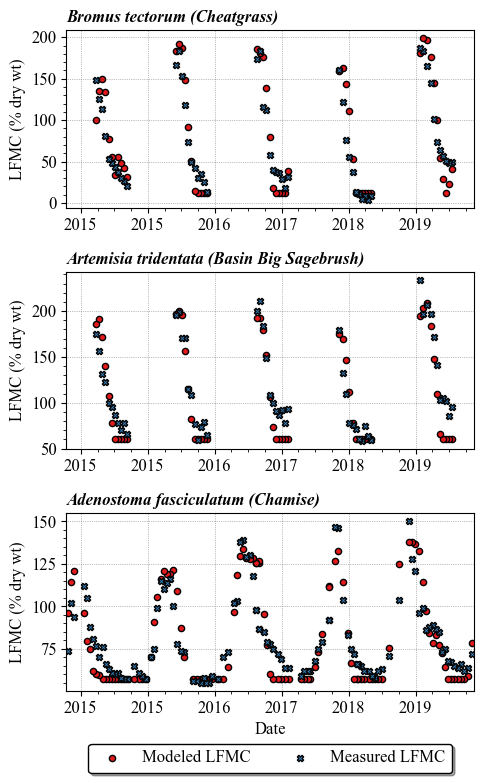

In [31]:
f,ax = plt.subplots(3,1,figsize=(5,8))
## Plot BroTec
MM_UT_BroTec.plot.scatter(x='DateTime',y='LFMC',ax=ax[0],marker=mkr_nf1,color=clr_nf1, edgecolor=clr_edg_nf)
MM_UT_BroTec.plot.scatter(x='DateTime',y='Percent',ax=ax[0],marker=mkr_nf2,color=clr_nf2, edgecolor=clr_edg_nf)
ax[0].set_xlim([datetime(2015, 1, 1), datetime(2019, 12, 31)])
ax[0].set_xlabel("")
ax[0].set_title("Bromus tectorum (Cheatgrass)", style='italic')

# Define the date format
date_form = DateFormatter("%Y")
ax[0].xaxis.set_major_formatter(date_form)
# Setting the number of ticks
ax[0].xaxis.set_major_locator(plt.MaxNLocator(7))
ax[0].set_xlabel('')
ax[0].set_ylabel('LFMC (% dry wt)')

## Plot ArtTri
ax[1].set_title("Artemisia tridentata (Basin Big Sagebrush)", style='italic')
MM_UT_ArtTri.plot.scatter(x='DateTime',y='LFMC',ax=ax[1],marker=mkr_nf1,color=clr_nf1, edgecolor=clr_edg_nf)
MM_UT_ArtTri.plot.scatter(x='DateTime',y='Percent',ax=ax[1],marker=mkr_nf2,color=clr_nf2, edgecolor=clr_edg_nf)
ax[1].set_xlim([datetime(2015, 1, 1), datetime(2019, 12, 31)])
ax[1].set_xlabel("")
ax[1].xaxis.set_major_formatter(date_form)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(7))
ax[1].set_xlabel('')
ax[1].set_ylabel('LFMC (% dry wt)')

## Plot AdeFas
ax[2].set_title("Adenostoma fasciculatum (Chamise)", style='italic')
MM_CA_Chamise.plot.scatter(x='DateTime',y='LFMC',ax=ax[2],marker=mkr_nf1,color=clr_nf1, edgecolor=clr_edg_nf,label='Modeled LFMC')
MM_CA_Chamise.plot.scatter(x='DateTime',y='Percent',ax=ax[2],marker=mkr_nf2,color=clr_nf2, edgecolor=clr_edg_nf,label='Measured LFMC')
ax[2].set_xlim([datetime(2015, 1, 1), datetime(2019, 12, 31)])
ax[2].set_xlabel("Date")
ax[2].xaxis.set_major_locator(plt.MaxNLocator(7))
ax[2].xaxis.set_major_formatter(date_form)
ax[2].set_xlabel('Date')
ax[2].set_ylabel('LFMC (% dry wt)')

ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=True, ncol=5)

## Write out the figure
f.tight_layout()
fout = "./Figures/CombinedGSILFMPlot.png" 
if fout != "":
    plt.savefig(fout,dpi=300, bbox_inches='tight',facecolor='white', transparent=False )


In [32]:
###############################################################
# Let's explore the green-up and smoothing period thresholds
# Develop a recommended value for default GSI settings
###############################################################

In [33]:
if SIM:
    # Test the default Green-up threshold 
    corrs = []
    DayRange = np.arange(7,100,7,dtype='int')
    for i in DayRange:
        print('Days: ', i)
        for j in range(0,10):
            GU = j / 10
            Days = int(i)
            #defParams = [-2, 5, 900, 4100, 36000, 39600, 0, 0.393701, Days,GU,Days]
            
            MM_UT_BroTec = GetMetMerge(Met421501, UT_BroTec,defParams,UseLFMMinMax=False,Lat=Lat421501, Herb=True)
            MM_UT_ArtTri = GetMetMerge(Met421501, UT_ArtTri,defParams,UseLFMMinMax=False,Lat=Lat421501)
            MM_CA_AdeFas = GetMetMerge(Met045433,CA_Chamise,defParams,UseLFMMinMax=False,Lat=Lat045433)
            
            MM_GSIDef = pd.concat([MM_UT_BroTec,MM_UT_ArtTri,MM_CA_AdeFas])
            MM_GSIDef = MM_GSIDef.drop(columns=['GACC','State','Group','Site','Date','Fuel','Unnamed: 7','DateTime',
                                                'DATE','Tmin','MaxT','MnRH','MxRH','VPDMax','VPDA','Prcp',
                                                'RunSumPrcp','MinTC','Dayl','JDay','GSI_PE_RS',
                                               'TminInd','VPDInd','DaylInd','PrcpInd','FMW','FMH'])
            # Append the correlation to the list
            corrs.append(MM_GSIDef.corr(method='spearman')['Percent'][1])


In [34]:
if SIM:
    arr = np.array(corrs)
    # Use around() to round the array
    rounded_corrs = np.around(arr,decimals=3)    
else:
    rounded_corrs = [0.552, 0.543, 0.5  , 0.48 , 0.466, 0.424, 0.394, 0.333, 0.293, 0.276, 0.691, 0.669, 0.646, 0.624, 0.571, 0.525, 0.435, 0.368,
       0.314, 0.292, 0.766, 0.765, 0.753, 0.724, 0.694, 0.604, 0.511, 0.412, 0.332, 0.299, 0.786, 0.791, 0.808, 0.779, 0.756, 0.719,
       0.606, 0.538, 0.335, 0.291, 0.771, 0.778, 0.802, 0.793, 0.785, 0.731, 0.606, 0.549, 0.436, 0.297, 0.755, 0.773, 0.795, 0.784,
       0.796, 0.796, 0.696, 0.55 , 0.526, 0.317, 0.722, 0.744, 0.763, 0.768, 0.768, 0.765, 0.737, 0.538, 0.489, 0.338, 0.697, 0.726,
       0.747, 0.749, 0.756, 0.767, 0.732, 0.576, 0.471, 0.339, 0.66 , 0.696, 0.708, 0.727, 0.728, 0.73 , 0.704, 0.571, 0.42 , 0.298,
       0.613, 0.639, 0.656, 0.674, 0.682, 0.682, 0.66 , 0.502, 0.389, 0.3  , 0.568, 0.592, 0.611, 0.631, 0.639, 0.642, 0.626, 0.491,
       0.393, 0.329, 0.517, 0.535, 0.556, 0.576, 0.602, 0.603, 0.565, 0.488, 0.41 , 0.332, 0.461, 0.478, 0.498, 0.516, 0.543, 0.549,
       0.516, 0.472, 0.377, 0.332, 0.4  , 0.419, 0.438, 0.46 , 0.489, 0.508, 0.459, 0.471, 0.408, 0.343]

Text(0, 0.5, 'Smoothing Period (days)')

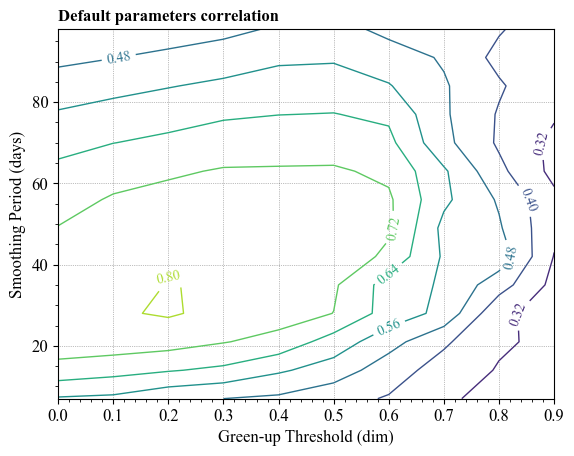

In [35]:
X = np.arange(0, 1, 0.1)
Y = np.arange(7,100,7,dtype='int')
corrs_new = np.array(rounded_corrs).reshape(len(Y), len(X))

fig, ax = plt.subplots()
CS = ax.contour(X, Y, corrs_new)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Default parameters correlation')
ax.set_xlabel("Green-up Threshold (dim)")
ax.set_ylabel("Smoothing Period (days)")

In [36]:


MM_UT_BroTec = GetMetMerge(Met421501, UT_BroTec,defParams,UseLFMMinMax=False,Lat=Lat421501, Herb=True)
MM_UT_ArtTri = GetMetMerge(Met421501, UT_ArtTri,defParams,UseLFMMinMax=False,Lat=Lat421501)
MM_CA_AdeFas = GetMetMerge(Met045433,CA_Chamise,defParams,UseLFMMinMax=False,Lat=Lat045433)

MM_GSIDef = pd.concat([MM_UT_BroTec,MM_UT_ArtTri,MM_CA_AdeFas])
MM_GSIDef = MM_GSIDef.drop(columns=['GACC','State','Group','Site','Date','Fuel','Unnamed: 7','DateTime',
                                    'DATE','Tmin','MaxT','MnRH','MxRH','VPDMax','VPDA','Prcp',
                                    'RunSumPrcp','MinTC','Dayl','JDay','GSI_PE_RS',
                                   'TminInd','VPDInd','DaylInd','PrcpInd','FMW','FMH'])
# Append the correlation to the list
MM_GSIDef.corr(method='spearman')['Percent'][1]

0.8083691168602929

In [37]:
# Fix the first comparions against V2 LFMC's
MM_UT_BroTec['FM'] = MM_UT_BroTec['FMH']
MM_UT_ArtTri['FM'] = MM_UT_BroTec['FMW']
MM_CA_AdeFas['FM'] = MM_CA_AdeFas['FMW']

MM_GSIDef = pd.concat([MM_UT_BroTec,MM_UT_ArtTri,MM_CA_AdeFas])
MM_GSIDef = MM_GSIDef.drop(columns=['GACC','State','Group','Site','Date','Fuel','Unnamed: 7','DateTime',
                                    'DATE','Tmin','MaxT','MnRH','MxRH','VPDMax','VPDA','Prcp',
                                    'RunSumPrcp','MinTC','Dayl','JDay','GSI_PE_RS',
                                   'TminInd','VPDInd','DaylInd','PrcpInd','FMW','FMH'])

MM_UT_BroTecOpt['FM'] = MM_UT_BroTecOpt['FMH']
MM_UT_ArtTriOpt['FM'] = MM_UT_BroTecOpt['FMW']
MM_CA_AdeFasOpt['FM'] = MM_CA_AdeFasOpt['FMW']
MM_GSIOpt= pd.concat([MM_UT_BroTecOpt,MM_UT_ArtTriOpt,MM_CA_AdeFasOpt])
MM_GSIOpt = MM_GSIOpt.drop(columns=['GACC','State','Group','Site','Date','Fuel','Unnamed: 7','DateTime',
                                    'DATE','Tmin','MaxT','MnRH','MxRH','VPDMax','VPDA','Prcp',
                                    'RunSumPrcp','MinTC','Dayl','JDay','GSI_PE_RS',
                                   'TminInd','VPDInd','DaylInd','PrcpInd','FMW','FMH'])


In [38]:
## Note: Need to correct these so that BroTec is being compared to FMH and not FMW

In [39]:
# Pooled correlation for all three species using default parameters
MM_GSIDef.corr(method='spearman')

,Percent,LFMC,FM
Percent,1.000000,0.808369,0.167865
LFMC,0.808369,1.000000,0.351849
FM,0.167865,0.351849,1.000000


In [40]:
MM_GSIOpt.corr(method='spearman')

,Percent,LFMC,FM
Percent,1.000000,0.921765,0.167865
LFMC,0.921765,1.000000,0.081397
FM,0.167865,0.081397,1.000000


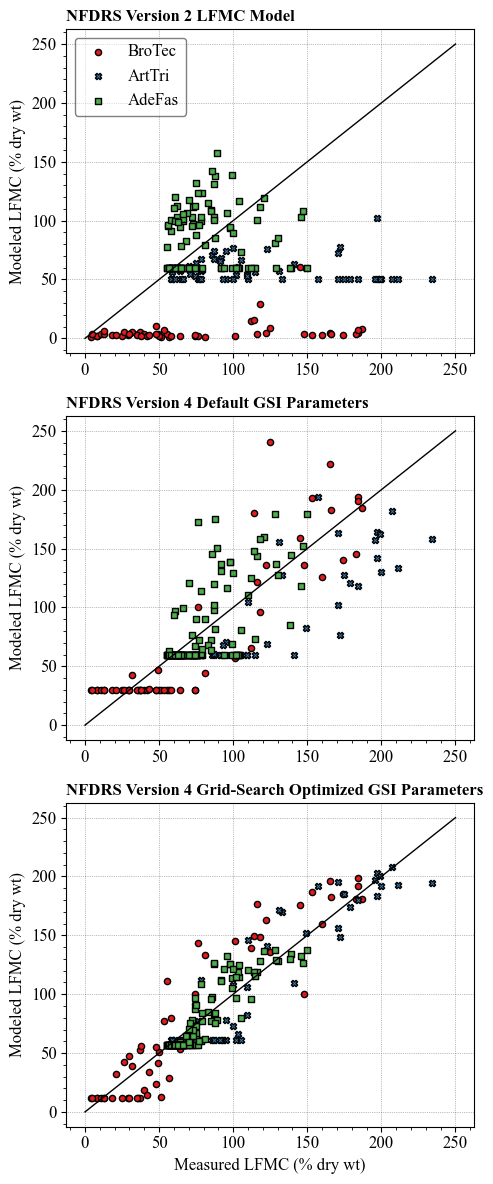

In [41]:
f,ax = plt.subplots(3,1,figsize=(5,12))
MM_UT_BroTec.plot.scatter(x='Percent',y='FMH',ax=ax[0],label="BroTec",marker=mkr_nf1,color=clr_nf1,edgecolor=clr_edg_nf)
MM_UT_ArtTri.plot.scatter(x='Percent',y='FMW',ax=ax[0],label="ArtTri",marker=mkr_nf2,color=clr_nf2,edgecolor=clr_edg_nf)
MM_CA_AdeFas.plot.scatter(x='Percent',y='FMW',ax=ax[0],label="AdeFas",marker=mkr_nf3,color=clr_nf3,edgecolor=clr_edg_nf)
ax[0].plot([0,250],[0,250],color='black')
ax[0].legend(loc='upper left')
ax[0].set_xlabel("")
ax[0].set_ylabel("Modeled LFMC (% dry wt)")
ax[0].set_title('NFDRS Version 2 LFMC Model')

MM_UT_BroTec.plot.scatter(x='Percent',y='LFMC',ax=ax[1],marker=mkr_nf1,color=clr_nf1,edgecolor=clr_edg_nf)
MM_UT_ArtTri.plot.scatter(x='Percent',y='LFMC',ax=ax[1],marker=mkr_nf2,color=clr_nf2,edgecolor=clr_edg_nf)
MM_CA_AdeFas.plot.scatter(x='Percent',y='LFMC',ax=ax[1],marker=mkr_nf3,color=clr_nf3,edgecolor=clr_edg_nf)
ax[1].plot([0,250],[0,250],color='black')
#ax[1].legend(loc='lower left',bbox_to_anchor=(1.0, 1.0))
ax[1].set_xlabel("")
ax[1].set_ylabel("Modeled LFMC (% dry wt)")
ax[1].set_title('NFDRS Version 4 Default GSI Parameters')

MM_UT_BroTecOpt.plot.scatter(x='Percent',y='LFMC',ax=ax[2],marker=mkr_nf1,color=clr_nf1,edgecolor=clr_edg_nf)
MM_UT_ArtTriOpt.plot.scatter(x='Percent',y='LFMC',ax=ax[2],marker=mkr_nf2,color=clr_nf2,edgecolor=clr_edg_nf)
MM_CA_AdeFasOpt.plot.scatter(x='Percent',y='LFMC',ax=ax[2],marker=mkr_nf3,color=clr_nf3,edgecolor=clr_edg_nf)
ax[2].plot([0,250],[0,250],color='black')
#ax[1].legend(loc='lower left',bbox_to_anchor=(1.0, 1.0))
ax[2].set_xlabel("Measured LFMC (% dry wt)")
ax[2].set_ylabel("Modeled LFMC (% dry wt)")
ax[2].set_title('NFDRS Version 4 Grid-Search Optimized GSI Parameters')

plt.tight_layout()
fout = './Figures/FuelMoistureComparisons_3Grid.png'
if fout != "":
    plt.savefig(fout,dpi=300, bbox_inches='tight',facecolor='white', transparent=False )


In [42]:
Met421501RunSumPrcp = Met421501.RunSumPrcp.dropna()
Met045433RunSumPrcp = Met045433.RunSumPrcp.dropna()

In [43]:
# Calculate the cumulative proportion of the data that falls below each value
cumulative = np.linspace(0, 1, len(Met421501RunSumPrcp))
cumulative2 = np.linspace(0, 1, len(Met045433RunSumPrcp))
# Sort the data in ascending order
sorted_data = np.sort(Met421501RunSumPrcp)
sorted_data2 = np.sort(Met045433RunSumPrcp)

# Calculate the cumulative proportion of the sorted data
cumulative_data = np.cumsum(sorted_data) / np.sum(sorted_data)
cumulative_data2 = np.cumsum(sorted_data2) / np.sum(sorted_data2)


Text(0.0, 1.0, 'Cumulative Distribution Function (CDF) of Running Total Precip (in)')

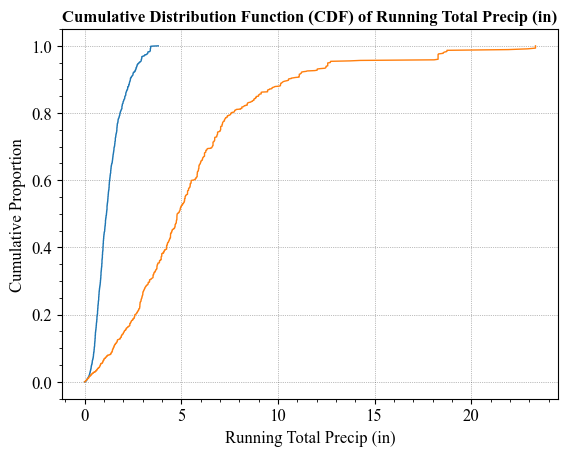

In [44]:
# Plot the CDF
plt.plot(sorted_data, cumulative_data)
plt.plot(sorted_data2, cumulative_data2)
# Add labels and title
plt.xlabel("Running Total Precip (in)")
plt.ylabel("Cumulative Proportion")
plt.title("Cumulative Distribution Function (CDF) of Running Total Precip (in)")

In [45]:
## Look up the percentiles of Cum Rainfall
print(stats.percentileofscore(Met421501.RunSumPrcp.dropna(), 0.393701))
print(stats.percentileofscore(Met421501.RunSumPrcp.dropna(), 1.1))
print(stats.percentileofscore(Met045433.RunSumPrcp.dropna(), 0.393701))
print(stats.percentileofscore(Met045433.RunSumPrcp.dropna(), 3.6))

27.663524707226507
75.64981433876035
60.02695417789758
84.64959568733154


In [46]:
print(stats.percentileofscore(Met421501.RunSumPrcp.dropna(), 1.1))

75.64981433876035
